# Text Summarizer using DL and NLP from the scratch in python

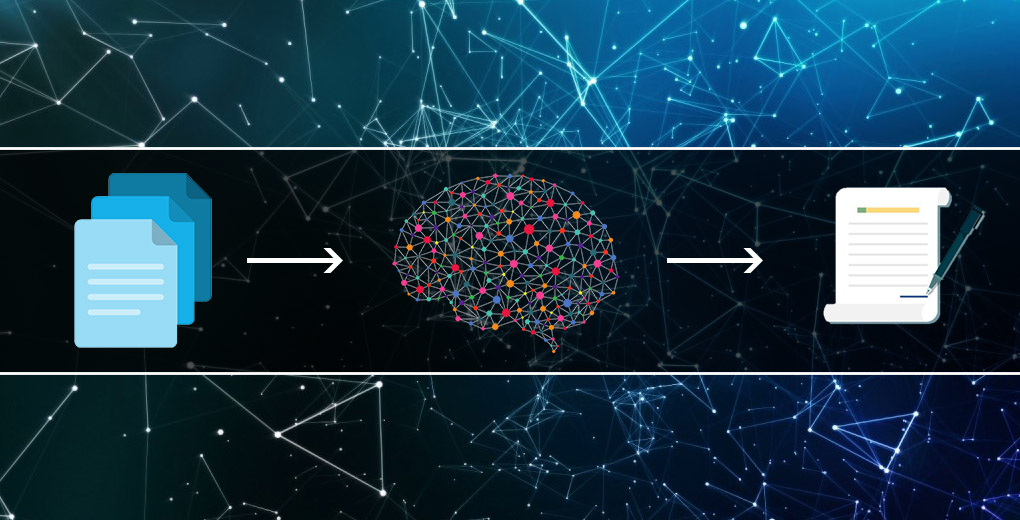

## Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012.

We’ll take a sample of 5,000 reviews to reduce the training time of our model.

In [2]:
Reviews = pd.read_csv(r"C:\Users\Leader Shop.DESKTOP-VA8306M\Downloads\Text_Summary\Reviews.csv",nrows=50000)

## Information about dataset


In [3]:
Reviews.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


# Drop Duplicates and NA values

In [4]:
Reviews.drop_duplicates(subset=['Text'],inplace=True) 
Reviews.dropna(axis=0,inplace=True)  

## Preprocessing

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove any text inside the parenthesis []

3.Remove (‘s)

4.Eliminate punctuations and special characters

5.Remove stopwords


In [5]:
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from attention import AttentionLayer
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
stop_words = set(stopwords.words('english')) 

def preprocess_text(Text , Stop_word=True):
    Text = Text.lower()
    Text = re.sub(r'<[^>]*>','',Text)
    Text = re.sub('"','',Text)
    Text = re.sub(r"'s\b",' ',Text)
    Text = re.sub(r"[^a-zA-Z]",' ',Text)
    if(Stop_word):
        tokens = [w for w in Text.split() if not w in stop_words]
   
   
    return ' '.join([word for word in Text.split()])

In [7]:
cleaned_text    = []
cleaned_summary = []

for w in Reviews['Text']:
    cleaned_text.append(preprocess_text(w)) 
for w in Reviews['Summary']:
    cleaned_summary.append(preprocess_text(w,False)) 

In [8]:
cnt=0
for i in cleaned_summary:
    if(len(i.split())<=9):
        cnt=cnt+1
print(cnt/len(cleaned_summary))

0.9584


We observe that 95% of the summaries have length below 9. So, we can fix maximum length of summary to 9.

Let us fix the maximum length of review to 30

In [9]:
max_text_len    = 30
max_summary_len = 9

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [10]:
cleaned_text    = np.array(cleaned_text)
cleaned_summary = np.array(cleaned_summary)

short_text   =[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        


In [11]:
Reviews = pd.DataFrame({'text':short_text,'summary':short_summary})

# Drop empty rows

In [12]:
Reviews.replace('', np.nan, inplace=True)
Reviews.dropna(axis=0,inplace=True)

Remember to add the **START** and **END** special tokens at the beginning and end of the summary. 

In [13]:
Reviews.summary = Reviews['summary'].apply(lambda x : '<<Start>> '+ x + '<<End>>')

we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10%

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(np.array(Reviews.text),np.array(Reviews.summary),test_size=0.1,random_state=0,shuffle=True) 

## Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary

In [15]:
from keras.preprocessing.text     import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

## Text Tokenizer

In [16]:
#prepare a tokenizer for reviews on training data
text_tokenizer = Tokenizer() 
text_tokenizer.fit_on_texts(list(x_train))

minimum    = 6
rare_count = 0
total_count= 0

for key,value in text_tokenizer.word_counts.items():
    if(value < minimum):
        rare_count      = rare_count + 1 
    total_count      = total_count + 1
    
    
print(f"Number of Words used less than {minimum+1} times >> {rare_count}")
print(f"which is {np.round(rare_count/total_count*100,2)}% of total words used")

Number of Words used less than 7 times >> 6930
which is 76.2% of total words used



* **total_count:**  the size of vocabulary (which means every unique words in the text)
 
* **rare_count:**  the no. of rare words whose count falls below minimum

*  **total_count - rare_count:**  the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [17]:
#prepare a tokenizer for reviews on training data
text_tokenizer = Tokenizer(num_words = total_count - rare_count) 
text_tokenizer.fit_on_texts(list(x_train))

#convert into integer sequences
x_train_seq    =   text_tokenizer.texts_to_sequences(x_train) 
x_val_seq      =   text_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train_seq,  maxlen = max_text_len, padding='post')
x_val      =   pad_sequences(x_val_seq,    maxlen = max_text_len, padding='post')


In [18]:
#size of vocabulary ( +1 for padding token)
x_voc   =  text_tokenizer.num_words + 1

## Summary Tokenizer

In [19]:
#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer()   
summary_tokenizer.fit_on_texts(list(y_train))

minimum    = 7
rare_count = 0
total_count= 0

for key,value in summary_tokenizer.word_counts.items():
    if(value < minimum):
        rare_count      = rare_count + 1 
    total_count         = total_count + 1
    
    
print(f"Number of Words used less than {minimum+1} times >> {rare_count}")
print(f"which is {np.round(rare_count/total_count*100,2)}% of total words used")

Number of Words used less than 8 times >> 3091
which is 85.48% of total words used


Let us define the tokenizer with top most common words for summary.

In [20]:
#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer(num_words = total_count - rare_count) 
summary_tokenizer.fit_on_texts(list(y_train))

#convert into integer sequences
y_train_seq    =   summary_tokenizer.texts_to_sequences(y_train) 
y_val_seq      =   summary_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen = max_summary_len, padding='post')
y_val      =   pad_sequences(y_val_seq,   maxlen = max_summary_len, padding='post')

In [21]:
#size of vocabulary
y_voc  =   summary_tokenizer.num_words +1   

Here, I am deleting the rows that contain only **START** and **END** tokens

In [22]:
y_train_indices = [i for i,sequence in enumerate(y_train) if len(sequence) ==2]
y_val_indices   = [i for i,sequence in enumerate(y_val)   if len(sequence) ==2]

y_train = np.delete(y_train,y_train_indices, axis=0)
x_train = np.delete(x_train,y_train_indices, axis=0)

y_val = np.delete(y_val,y_val_indices, axis=0)
x_val = np.delete(x_val,y_val_indices, axis=0)

# Model building

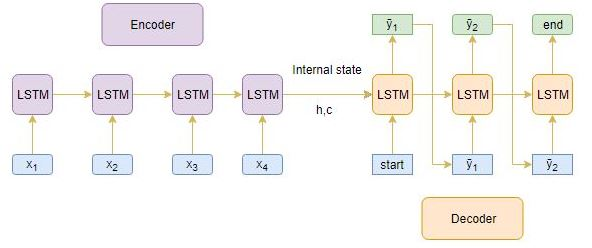

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [23]:
latent_dim    = 300
embedding_dim = 100

In [24]:
from keras import backend as K 
K.clear_session()

## Encoder

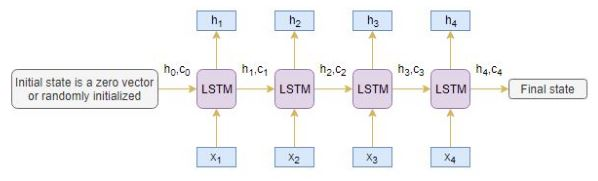

In [25]:

# input layer
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## decoder using `encoder_states` as initial  state

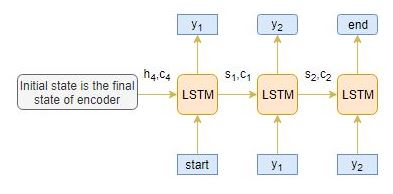

In [26]:
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])


## Attention Layer

In [27]:
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

## Last Layer

In [28]:
#dense layer
decoder_dense   =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

## Define the model 

In [29]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      216500      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [32]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 8305 samples, validate on 923 samples
Epoch 1/50
8305/8305 [==============================] - 176s 21ms/sample - loss: 2.2653 - accuracy: 0.6210 - val_loss: 1.7914 - val_accuracy: 0.7095
Epoch 2/50
8305/8305 [==============================] - 177s 21ms/sample - loss: 1.8010 - accuracy: 0.7058 - val_loss: 1.7155 - val_accuracy: 0.7096
Epoch 3/50
8305/8305 [==============================] - 188s 23ms/sample - loss: 1.7263 - accuracy: 0.7069 - val_loss: 1.6541 - val_accuracy: 0.7105
Epoch 4/50
8305/8305 [==============================] - 198s 24ms/sample - loss: 1.6794 - accuracy: 0.7083 - val_loss: 1.6301 - val_accuracy: 0.7137
Epoch 5/50
8305/8305 [==============================] - 216s 26ms/sample - loss: 1.6342 - accuracy: 0.7107 - val_loss: 1.5960 - val_accuracy: 0.7148
Epoch 6/50
8305/8305 [==============================] - 211s 25ms/sample - loss: 1.5935 - accuracy: 0.7135 - val_loss: 1.5650 - val_accuracy: 0.7165
Epoch 7/50
8305/8305 [==============================] - 194

# Inference

Set up the inference for the encoder and decoder

In [35]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [38]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [39]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [40]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [41]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [42]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [93]:
def Call_interface(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['start']

    End_seq = False
    decoded_sentence = ''
    while not End_seq:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
       
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len-1)):
            End_seq = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [94]:
def summary_(input_seq):
    newString =''
    for i in input_seq:
        if((i != 0 and i != target_word_index['start']) and i != target_word_index['end']):
            newString = newString+reverse_target_word_index[i]+' '
    return newString

def text_(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString + reverse_source_word_index[i]+' '
    return newString

In [95]:
reverse_target_word_index = summary_tokenizer.index_word 
reverse_source_word_index = text_tokenizer.index_word 
target_word_index = summary_tokenizer.word_index

In [96]:
print("Review:",text_(x_val[10]))
print("Original summary:",summary_(y_val[10]))
print("Predicted summary:",Call_interface(x_val[10].reshape(1,max_text_len)))
print("\n")

Review: my favorite is bigelow cinnamon stick tea i drink it every day at work and absolutely love it a little sugar and cream and its perfect 
Original summary: love this tea 
Predicted summary:  best tea




In [97]:
print("Review:",text_(x_val[80]))
print("Original summary:",summary_(y_val[80]))
print("Predicted summary:",Call_interface(x_val[80].reshape(1,max_text_len)))
print("\n")

Review: the hot chocolate is my husband favorite service was also great as it usually is very now with winter coming on 
Original summary: great hot chocolate 
Predicted summary:  great taste


